**Download**

In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
# from torchvision.datasets import CIFAR10
# import torchvision.transforms as transforms

# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# dataset = CIFAR10(root='./CIFARdata', download=True, transform=transform)


In [1]:
import torch

ckpt_path = "./runs/ddpm_cifar10/checkpoints/ckpt_last.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")

print("Checking Model weights...")
has_nan_model = False
for k, v in ckpt["model"].items():
    if torch.isnan(v).any() or torch.isinf(v).any():
        print(f"!!! MODEL param {k} contains NaN or Inf!")
        has_nan_model = True
        break
if not has_nan_model:
    print("Model weights look OK.")

print("\nChecking EMA weights...")
has_nan_ema = False
if "shadow" in ckpt["ema"]:
    for k, v in ckpt["ema"]["shadow"].items():
        if torch.isnan(v).any() or torch.isinf(v).any():
            print(f"!!! EMA param {k} contains NaN or Inf!")
            has_nan_ema = True
            break
else:
    print("No shadow params found in EMA dict.")

if not has_nan_ema:
    print("EMA weights look OK.")

Checking Model weights...
Model weights look OK.

Checking EMA weights...
EMA weights look OK.


**Begin-GAN**

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch_fidelity
from tqdm import tqdm

In [4]:
class Config:
    workers = 2             # 数据加载线程数
    batch_size = 128        # 批大小
    image_size = 32         # CIFAR-10 尺寸
    nc = 3                  # 彩色图片通道数
    nz = 100                # 噪声向量(Latent vector)维度
    ngf = 64                # 生成器特征图深度
    ndf = 64                # 判别器特征图深度
    num_epochs = 50         # 训练轮数 (建议50-200)
    lr = 0.0002             # 学习率
    beta1 = 0.5             # Adam优化器的Beta1
    ngpu = 1                # 可用GPU数量
    out_dir = './output'    # 结果保存路径
    data_root = './CIFARdata'    # 数据集下载路径

opt = Config()
os.makedirs(opt.out_dir, exist_ok=True)
os.makedirs(f"{opt.out_dir}/generated_images", exist_ok=True)
os.makedirs(f"{opt.out_dir}/real_images", exist_ok=True)

# 设置随机种子以便复现
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0" if (torch.cuda.is_available() and opt.ngpu > 0) else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
dataset = dset.CIFAR10(root=opt.data_root, 
                       download=True, 
                       transform=transforms.Compose([
                           transforms.Resize(opt.image_size),
                           transforms.CenterCrop(opt.image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化到 [-1, 1]
                       ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size,
                                         shuffle=True, num_workers=opt.workers)

**模型定义**

In [6]:
# 权重初始化函数：DCGAN论文建议从均值为0，标准差为0.02的正态分布初始化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 输入是 Z (噪声向量)
            # ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias)
            nn.ConvTranspose2d(opt.nz, opt.ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(opt.ngf * 4),
            nn.ReLU(True),
            # 状态尺寸: (ngf*4) x 4 x 4

            nn.ConvTranspose2d(opt.ngf * 4, opt.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 2),
            nn.ReLU(True),
            # 状态尺寸: (ngf*2) x 8 x 8

            nn.ConvTranspose2d(opt.ngf * 2, opt.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            # 状态尺寸: (ngf) x 16 x 16

            nn.ConvTranspose2d(opt.ngf, opt.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 状态尺寸: (nc) x 32 x 32
            # 输出范围 [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 输入尺寸: (nc) x 32 x 32
            nn.Conv2d(opt.nc, opt.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态尺寸: (ndf) x 16 x 16

            nn.Conv2d(opt.ndf, opt.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态尺寸: (ndf*2) x 8 x 8

            nn.Conv2d(opt.ndf * 2, opt.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态尺寸: (ndf*4) x 4 x 4

            nn.Conv2d(opt.ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 输出概率
        )

    def forward(self, input):
        return self.main(input)

# 初始化模型
netG = Generator(opt.ngpu).to(device)
netG.apply(weights_init)
netD = Discriminator(opt.ngpu).to(device)
netD.apply(weights_init)

# 定义损失函数和优化器
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, opt.nz, 1, 1, device=device) # 用于可视化进度的固定噪声
real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

**指标计算函数**

In [7]:
def fidelity_metric(generated_images_path, real_images_path):
    """
    使用torch-fidelity计算IS和FID
    """
    print(f"Calculating metrics between {generated_images_path} and {real_images_path}...")
    metrics_dict = torch_fidelity.calculate_metrics(
        input1=generated_images_path,
        input2=real_images_path,
        cuda=True,
        isc=True,
        fid=True,
        kid=False, # KID计算较慢，此处可选关闭
        verbose=False
    )
    return metrics_dict

def prepare_evaluation_data(generator, num_samples=2000):
    """
    生成图片并保存到磁盘，同时将部分真实测试集图片保存到磁盘，以便计算FID。
    注意：FID通常需要在完整的测试集(10k)上计算才最准确，这里为了演示速度设为2000。
    做最终报告时建议设为 10000。
    """
    generator.eval()
    
    # 1. 保存生成的图片 (Fake)
    gen_path = os.path.join(opt.out_dir, "eval_generated")
    os.makedirs(gen_path, exist_ok=True)
    
    # 清空目录
    for f in os.listdir(gen_path): os.remove(os.path.join(gen_path, f))
    
    with torch.no_grad():
        for i in range(0, num_samples, opt.batch_size):
            b_size = min(opt.batch_size, num_samples - i)
            noise = torch.randn(b_size, opt.nz, 1, 1, device=device)
            fake = generator(noise)
            # 反归一化: [-1, 1] -> [0, 1]
            fake = (fake + 1) / 2.0
            for j in range(b_size):
                vutils.save_image(fake[j], f"{gen_path}/fake_{i+j}.png")

    # 2. 保存真实测试集图片 (Real) - 只需做一次，这里检查如果存在就不重复保存了
    real_path = os.path.join(opt.out_dir, "eval_real")
    if not os.path.exists(real_path) or len(os.listdir(real_path)) < num_samples:
        os.makedirs(real_path, exist_ok=True)
        test_dataset = dset.CIFAR10(root=opt.data_root, download=True, train=False, # 使用测试集
                                    transform=transforms.Compose([
                                       transforms.Resize(opt.image_size),
                                       transforms.ToTensor() # 注意这里不需要Normalize到-1,1，因为保存图片需要0-1
                                   ]))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=opt.batch_size, shuffle=False)
        
        count = 0
        for i, (imgs, _) in enumerate(test_loader):
            for j in range(imgs.size(0)):
                if count >= num_samples: break
                vutils.save_image(imgs[j], f"{real_path}/real_{count}.png")
                count += 1
            if count >= num_samples: break
            
    return gen_path, real_path

**Training Loop**

In [8]:
import ssl

# ==========================================
# 解决 SSL: CERTIFICATE_VERIFY_FAILED 报错
# ==========================================
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

print("已禁用SSL证书验证，正在重试下载...")

已禁用SSL证书验证，正在重试下载...


In [9]:
print("Starting Training Loop...")

img_list = []
G_losses = []
D_losses = []

for epoch in range(opt.num_epochs):
    # 训练模式
    netG.train()
    netD.train()
    
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for i, data in loop:
        # -----------------------------------------------------------
        # (1) 更新判别器 D: 最大化 log(D(x)) + log(1 - D(G(z)))
        # -----------------------------------------------------------
        netD.zero_grad()
        # 1.1 真实图片训练
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 1.2 生成图片训练
        noise = torch.randn(b_size, opt.nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1) # detach避免G的梯度更新
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # -----------------------------------------------------------
        # (2) 更新生成器 G: 最大化 log(D(G(z)))
        # -----------------------------------------------------------
        netG.zero_grad()
        label.fill_(real_label)  # 对于生成器，假图片的标签设为真（为了欺骗D）
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 更新进度条
        loop.set_description(f"Epoch [{epoch+1}/{opt.num_epochs}]")
        loop.set_postfix(Loss_D=errD.item(), Loss_G=errG.item())
        
        # 记录损失
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # --- 每个Epoch结束后的操作 ---
    
    # 1. 主观评价：保存生成图片网格
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    # 保存训练过程中的网格图
    vutils.save_image(fake, f'{opt.out_dir}/epoch_{epoch+1}_fake.png', normalize=True)
    
    # 2. 客观评价：每10个Epoch或最后一个Epoch计算一次IS/FID
    # (FID计算比较耗时，不建议每个epoch都跑)
    if (epoch + 1) % 10 == 0 or (epoch + 1) == opt.num_epochs:
        print(f"\nCalculating IS/FID at epoch {epoch+1}...")
        gen_path, real_path = prepare_evaluation_data(netG, num_samples=2000) # 演示用2000张
        metrics = fidelity_metric(gen_path, real_path)
        print(f"Metrics at Epoch {epoch+1}:")
        print(f"  Inception Score: {metrics['inception_score_mean']:.4f}")
        print(f"  FID: {metrics['frechet_inception_distance']:.4f}")

Starting Training Loop...



Calculating IS/FID at epoch 10...
Calculating metrics between ./output/eval_generated and ./output/eval_real...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:21<00:00, 4.38MB/s]
/root/miniconda3/lib/python3.10/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


Metrics at Epoch 10:
  Inception Score: 3.9888
  FID: 98.1011



Calculating IS/FID at epoch 20...
Calculating metrics between ./output/eval_generated and ./output/eval_real...
Metrics at Epoch 20:
  Inception Score: 5.0584
  FID: 76.2223



Calculating IS/FID at epoch 30...
Calculating metrics between ./output/eval_generated and ./output/eval_real...
Metrics at Epoch 30:
  Inception Score: 5.4011
  FID: 66.6398



Calculating IS/FID at epoch 40...
Calculating metrics between ./output/eval_generated and ./output/eval_real...
Metrics at Epoch 40:
  Inception Score: 5.8105
  FID: 62.2366



Calculating IS/FID at epoch 50...
Calculating metrics between ./output/eval_generated and ./output/eval_real...
Metrics at Epoch 50:
  Inception Score: 6.0036
  FID: 62.3561


In [10]:
# 保存最终模型
torch.save(netG.state_dict(), f'{opt.out_dir}/netG_final.pth')
torch.save(netD.state_dict(), f'{opt.out_dir}/netD_final.pth')

print("Training Finished!")

Training Finished!


**evaluate-GAN**

In [11]:
import os
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch_fidelity
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# =================配置参数 (需与训练时一致)=================
class Config:
    image_size = 32
    nc = 3
    nz = 100
    ngf = 64
    batch_size = 64
    workers = 2
    data_root = './CIFARdata'    # 数据集路径
    model_path = './output/netG_final.pth' # 训练好的模型路径
    out_dir = './output_evaluation'  # 评估结果保存路径

opt = Config()
os.makedirs(opt.out_dir, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# =================模型定义 (必须与训练代码一致)=================
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(opt.nz, opt.ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(opt.ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(opt.ngf * 4, opt.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(opt.ngf * 2, opt.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(opt.ngf, opt.nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

# 加载模型
netG = Generator().to(device)
if os.path.exists(opt.model_path):
    netG.load_state_dict(torch.load(opt.model_path, map_location=device))
    print("模型加载成功！")
else:
    raise FileNotFoundError(f"未找到模型文件: {opt.model_path}")
netG.eval()

# =================工具函数=================

def save_image_folder(dataset, save_path, num_samples=2000):
    """将Dataset中的图片保存到文件夹，用于FID计算"""
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False)
    count = 0
    print(f"正在准备数据: {save_path} ...")
    for imgs, _ in loader:
        for i in range(imgs.size(0)):
            if count >= num_samples: return
            # 假设Dataset已经是ToTensor后的，这里直接保存
            # 如果dataset有Normalize，这里其实应该反归一化，但为了对比FID，只要Real和Fake处理一致即可
            # 通常Dataset读取出来是 Tensor，我们需要存为 PNG
            vutils.save_image(imgs[i], f"{save_path}/{count}.png", normalize=True) 
            count += 1

def generate_fake_images(generator, save_path, num_samples=2000):
    """生成图片保存到文件夹"""
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    print(f"正在生成图片: {save_path} ...")
    batch_size = 50
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            noise = torch.randn(batch_size, opt.nz, 1, 1, device=device)
            fake = generator(noise)
            for j in range(batch_size):
                if i + j >= num_samples: break
                vutils.save_image(fake[j], f"{save_path}/{i+j}.png", normalize=True)

# ================= 任务1：客观指标分析 (FID/IS) =================
def analyze_objective_metrics():
    print("\n>>> 开始客观指标分析 (FID/IS)...")
    
    # 1. 准备路径
    path_gen = os.path.join(opt.out_dir, "fake_images")
    path_real_train = os.path.join(opt.out_dir, "real_train_images")
    path_real_test = os.path.join(opt.out_dir, "real_test_images")
    
    # 2. 生成假图片
    generate_fake_images(netG, path_gen, num_samples=2000) # 样本越多越准，推荐10000
    
    # 3. 准备真图片 (训练集 和 测试集)
    # 注意：这里transform不需要Normalize，因为save_image会自动处理，或者我们需要原始像素
    transform = transforms.Compose([
        transforms.Resize(opt.image_size),
        transforms.ToTensor(),
    ])
    
    train_set = dset.CIFAR10(root=opt.data_root, download=True, train=True, transform=transform)
    test_set = dset.CIFAR10(root=opt.data_root, download=True, train=False, transform=transform)
    
    save_image_folder(train_set, path_real_train, num_samples=2000)
    save_image_folder(test_set, path_real_test, num_samples=2000)
    
    # 4. 计算指标
    metrics = {}
    
    print("计算: 生成图像 vs 训练集 (检查记忆/过拟合)...")
    m1 = torch_fidelity.calculate_metrics(input1=path_gen, input2=path_real_train, cuda=True, isc=True, fid=True, verbose=False)
    metrics['train_fid'] = m1['frechet_inception_distance']
    metrics['is'] = m1['inception_score_mean'] # IS只看生成图像，跟对比集无关，算一次即可
    
    print("计算: 生成图像 vs 测试集 (检查泛化能力)...")
    m2 = torch_fidelity.calculate_metrics(input1=path_gen, input2=path_real_test, cuda=True, isc=False, fid=True, verbose=False)
    metrics['test_fid'] = m2['frechet_inception_distance']
    
    print("\n====== 最终结果 ======")
    print(f"Inception Score (IS): {metrics['is']:.4f} (越高越好)")
    print(f"FID (vs Training Set): {metrics['train_fid']:.4f}")
    print(f"FID (vs Test Set):     {metrics['test_fid']:.4f} (越低越好)")
    
    return metrics

# ================= 任务2：主观可视化 (Real vs Fake) =================
def visualize_real_vs_fake():
    print("\n>>> 生成主观对比图...")
    # 获取一些真实图片
    transform = transforms.Compose([
            transforms.Resize(opt.image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    test_set = dset.CIFAR10(root=opt.data_root, download=True, train=False, transform=transform)
    real_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
    real_batch = next(iter(real_loader))[0].to(device)
    
    # 生成一些假图片
    noise = torch.randn(32, opt.nz, 1, 1, device=device)
    with torch.no_grad():
        fake_batch = netG(noise)
        
    # 拼接
    real_grid = vutils.make_grid(real_batch, padding=2, normalize=True).cpu()
    fake_grid = vutils.make_grid(fake_batch, padding=2, normalize=True).cpu()
    
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images (Test Set)")
    plt.imshow(np.transpose(real_grid, (1, 2, 0)))
    
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(fake_grid, (1, 2, 0)))
    
    plt.savefig(f"{opt.out_dir}/comparison_real_vs_fake.png")
    print(f"对比图已保存: {opt.out_dir}/comparison_real_vs_fake.png")

# ================= 任务3：失败案例分析 (Failure Cases) =================
def analyze_failure_cases():
    print("\n>>> 生成潜在失败案例网格...")
    # 生成一大批图片 (例如 100 张)，保存成大网格
    # 在报告中，你可以圈出那些看起来像"噪声"、"只有纹理没有物体"或者"变形严重"的图片
    noise = torch.randn(100, opt.nz, 1, 1, device=device)
    with torch.no_grad():
        fake = netG(noise)
        
    grid = vutils.make_grid(fake, nrow=10, padding=2, normalize=True).cpu()
    
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title("Generated Grid for Failure Analysis")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.savefig(f"{opt.out_dir}/failure_case_grid.png")
    print(f"失败案例分析图已保存: {opt.out_dir}/failure_case_grid.png")


模型加载成功！



>>> 开始客观指标分析 (FID/IS)...
正在生成图片: ./output_evaluation/fake_images ...
正在准备数据: ./output_evaluation/real_train_images ...
正在准备数据: ./output_evaluation/real_test_images ...
计算: 生成图像 vs 训练集 (检查记忆/过拟合)...
计算: 生成图像 vs 测试集 (检查泛化能力)...

====== 最终结果 ======
Inception Score (IS): 5.9584 (越高越好)
FID (vs Training Set): 62.3463
FID (vs Test Set):     62.7472 (越低越好)

>>> 生成主观对比图...
对比图已保存: ./output_evaluation/comparison_real_vs_fake.png

>>> 生成潜在失败案例网格...
失败案例分析图已保存: ./output_evaluation/failure_case_grid.png

提示：请手动将 output/ 文件夹下不同 Epoch 的图片拼贴在一起，
并在报告中展示，以说明随着训练迭代轮数增加，生成图像的变化。


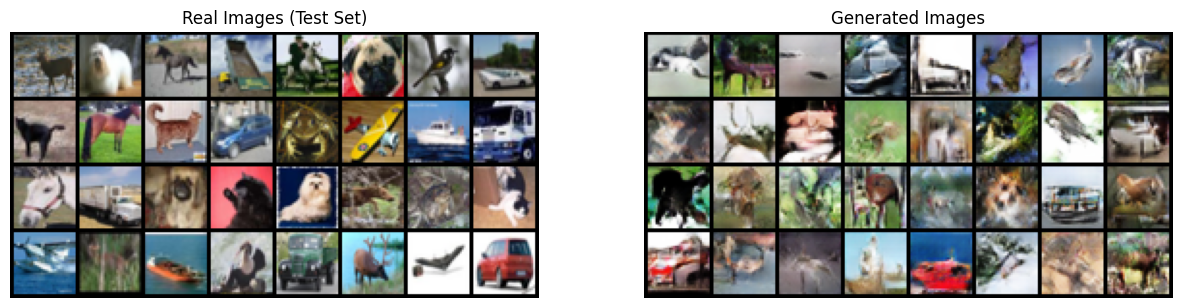

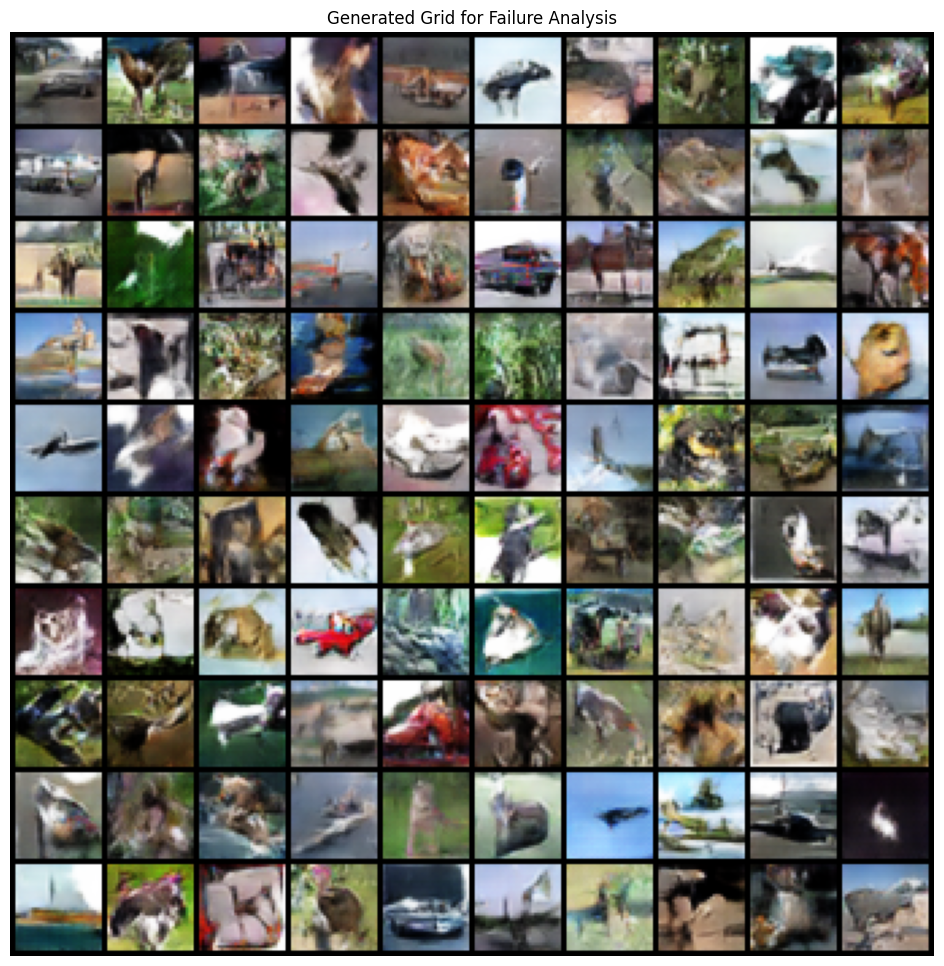

In [12]:
if __name__ == '__main__':
    # 1. 运行客观分析
    metrics = analyze_objective_metrics()
    
    # 2. 运行主观对比
    visualize_real_vs_fake()
    
    # 3. 生成失败案例素材
    analyze_failure_cases()
    
    # 4. 进化过程 (尝试读取output文件夹下的 epoch_x.png)
    # 如果你之前的 output 文件夹里还有 epoch_1_fake.png 等文件
    print("\n提示：请手动将 output/ 文件夹下不同 Epoch 的图片拼贴在一起，")
    print("并在报告中展示，以说明随着训练迭代轮数增加，生成图像的变化。")